In [2]:
import pandas as pd
import numpy as np
import talib
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import shap
import plotly.express as px
import plotly.graph_objects as go
import sys

In [3]:
df = pd.read_csv('meta_historical.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Close/Last'] = df['Close/Last'].str.replace("$", "", case=False, regex=False)
df = df.astype({'Close/Last': float})
df['Open'] = df['Open'].str.replace("$", "", case=False, regex=False)
df = df.astype({'Open': float})
df['High'] = df['High'].str.replace("$", "", case=False, regex=False)
df = df.astype({'High': float})
df['Low'] = df['Low'].str.replace("$", "", case=False, regex=False)
df = df.astype({'Low': float})
df['Return'] = df['Close/Last'].pct_change()
df.sort_values(by='Date',inplace=True)

In [4]:
df

,Date,Close/Last,Volume,Open,High,Low,Return
2515,2015-02-09,74.44,16182700,74.050,74.83,73.45,-0.009975
2514,2015-02-10,75.19,15783750,74.850,75.34,74.50,-0.017253
2513,2015-02-11,76.51,20817690,75.090,76.75,75.03,0.003673
2512,2015-02-12,76.23,17212100,76.860,76.87,75.89,0.006470
2511,2015-02-13,75.74,18487260,76.460,76.48,75.50,0.001852
...,...,...,...,...,...,...,...
4,2025-02-03,697.46,21415740,675.910,704.00,675.25,-0.009557
3,2025-02-04,704.19,13826270,702.500,707.71,691.61,-0.000965
2,2025-02-05,704.87,17793770,703.550,718.14,699.01,-0.010000
1,2025-02-06,711.99,13080690,705.880,718.90,703.50,-0.003541


In [5]:
sp500 = yf.download('^GSPC', start='2015-02-09', end='2025-02-07')
vix = yf.download('^VIX', start='2015-02-09', end='2025-02-07')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
sp500.columns = sp500.columns.get_level_values(0)
vix.columns = vix.columns.get_level_values(0)

In [7]:
vix

Price,Close,High,Low,Open,Volume
Date,,,,,
2015-02-09,18.549999,19.280001,18.209999,19.160000,0
2015-02-10,17.230000,18.360001,16.969999,17.719999,0
2015-02-11,16.959999,17.809999,16.820000,17.430000,0
2015-02-12,15.340000,16.469999,15.280000,16.389999,0
2015-02-13,14.690000,15.640000,14.690000,15.110000,0
...,...,...,...,...,...
2025-01-31,16.430000,17.090000,14.900000,15.450000,0
2025-02-03,18.620001,20.420000,17.660000,20.360001,0
2025-02-04,17.209999,19.110001,16.780001,18.780001,0


In [8]:
sp500

Price,Close,High,Low,Open,Volume
Date,,,,,
2015-02-09,2046.739990,2056.159912,2041.880005,2053.469971,3549540000
2015-02-10,2068.590088,2070.860107,2048.620117,2049.379883,3669850000
2015-02-11,2068.530029,2073.479980,2057.989990,2068.550049,3596860000
2015-02-12,2088.479980,2088.530029,2069.979980,2069.979980,3788350000
2015-02-13,2096.989990,2097.030029,2086.699951,2088.780029,3527450000
...,...,...,...,...,...
2025-01-31,6040.529785,6120.910156,6030.930176,6096.790039,4843770000
2025-02-03,5994.569824,6022.129883,5923.930176,5969.649902,4797210000
2025-02-04,6037.879883,6042.479980,5990.870117,5998.140137,4410160000


In [9]:
df = pd.merge(df, sp500[['Close']], left_on='Date', right_index=True, how='left', suffixes=('', '_SP500'))
df = pd.merge(df, vix[['Close']], left_on='Date', right_index=True, how='left', suffixes=('', '_VIX'))

In [10]:
df

,Date,Close/Last,Volume,Open,High,Low,Return,Close,Close_VIX
2515,2015-02-09,74.44,16182700,74.050,74.83,73.45,-0.009975,2046.739990,18.549999
2514,2015-02-10,75.19,15783750,74.850,75.34,74.50,-0.017253,2068.590088,17.230000
2513,2015-02-11,76.51,20817690,75.090,76.75,75.03,0.003673,2068.530029,16.959999
2512,2015-02-12,76.23,17212100,76.860,76.87,75.89,0.006470,2088.479980,15.340000
2511,2015-02-13,75.74,18487260,76.460,76.48,75.50,0.001852,2096.989990,14.690000
...,...,...,...,...,...,...,...,...,...
4,2025-02-03,697.46,21415740,675.910,704.00,675.25,-0.009557,5994.569824,18.620001
3,2025-02-04,704.19,13826270,702.500,707.71,691.61,-0.000965,6037.879883,17.209999
2,2025-02-05,704.87,17793770,703.550,718.14,699.01,-0.010000,6061.479980,15.770000
1,2025-02-06,711.99,13080690,705.880,718.90,703.50,-0.003541,6083.569824,15.500000


In [11]:
df.rename(columns={'Close': 'Close_SP500'}, inplace=True)
df

,Date,Close/Last,Volume,Open,High,Low,Return,Close_SP500,Close_VIX
2515,2015-02-09,74.44,16182700,74.050,74.83,73.45,-0.009975,2046.739990,18.549999
2514,2015-02-10,75.19,15783750,74.850,75.34,74.50,-0.017253,2068.590088,17.230000
2513,2015-02-11,76.51,20817690,75.090,76.75,75.03,0.003673,2068.530029,16.959999
2512,2015-02-12,76.23,17212100,76.860,76.87,75.89,0.006470,2088.479980,15.340000
2511,2015-02-13,75.74,18487260,76.460,76.48,75.50,0.001852,2096.989990,14.690000
...,...,...,...,...,...,...,...,...,...
4,2025-02-03,697.46,21415740,675.910,704.00,675.25,-0.009557,5994.569824,18.620001
3,2025-02-04,704.19,13826270,702.500,707.71,691.61,-0.000965,6037.879883,17.209999
2,2025-02-05,704.87,17793770,703.550,718.14,699.01,-0.010000,6061.479980,15.770000
1,2025-02-06,711.99,13080690,705.880,718.90,703.50,-0.003541,6083.569824,15.500000


In [12]:
df['Price_Change'] = (df['Close/Last'].shift(-1) - df['Close/Last']) / df['Close/Last']
# df['Target'] = (df['Price_Change'] >= 0.01).astype(int)
# df.at[0, 'Target'] = np.nan
# df = df.dropna()
# df = df.iloc[:-1]
df

,Date,Close/Last,Volume,Open,High,Low,Return,Close_SP500,Close_VIX,Price_Change
2515,2015-02-09,74.44,16182700,74.050,74.83,73.45,-0.009975,2046.739990,18.549999,0.010075
2514,2015-02-10,75.19,15783750,74.850,75.34,74.50,-0.017253,2068.590088,17.230000,0.017556
2513,2015-02-11,76.51,20817690,75.090,76.75,75.03,0.003673,2068.530029,16.959999,-0.003660
2512,2015-02-12,76.23,17212100,76.860,76.87,75.89,0.006470,2088.479980,15.340000,-0.006428
2511,2015-02-13,75.74,18487260,76.460,76.48,75.50,0.001852,2096.989990,14.690000,-0.001848
...,...,...,...,...,...,...,...,...,...,...
4,2025-02-03,697.46,21415740,675.910,704.00,675.25,-0.009557,5994.569824,18.620001,0.009649
3,2025-02-04,704.19,13826270,702.500,707.71,691.61,-0.000965,6037.879883,17.209999,0.000966
2,2025-02-05,704.87,17793770,703.550,718.14,699.01,-0.010000,6061.479980,15.770000,0.010101
1,2025-02-06,711.99,13080690,705.880,718.90,703.50,-0.003541,6083.569824,15.500000,0.003553


In [13]:
df['Target'] = (df['Price_Change'] >= 0.01).astype(int)
df.at[0, 'Target'] = np.nan
df

,Date,Close/Last,Volume,Open,High,Low,Return,Close_SP500,Close_VIX,Price_Change,Target
2515,2015-02-09,74.44,16182700,74.050,74.83,73.45,-0.009975,2046.739990,18.549999,0.010075,1.0
2514,2015-02-10,75.19,15783750,74.850,75.34,74.50,-0.017253,2068.590088,17.230000,0.017556,1.0
2513,2015-02-11,76.51,20817690,75.090,76.75,75.03,0.003673,2068.530029,16.959999,-0.003660,0.0
2512,2015-02-12,76.23,17212100,76.860,76.87,75.89,0.006470,2088.479980,15.340000,-0.006428,0.0
2511,2015-02-13,75.74,18487260,76.460,76.48,75.50,0.001852,2096.989990,14.690000,-0.001848,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4,2025-02-03,697.46,21415740,675.910,704.00,675.25,-0.009557,5994.569824,18.620001,0.009649,0.0
3,2025-02-04,704.19,13826270,702.500,707.71,691.61,-0.000965,6037.879883,17.209999,0.000966,0.0
2,2025-02-05,704.87,17793770,703.550,718.14,699.01,-0.010000,6061.479980,15.770000,0.010101,1.0
1,2025-02-06,711.99,13080690,705.880,718.90,703.50,-0.003541,6083.569824,15.500000,0.003553,0.0


In [14]:
df.value_counts('Target')

Target
0.0    1757
1.0     758
Name: count, dtype: int64

<h1>Adding Technical Indicators</h1>

---

**Moving Average (MA)** is the average price of a stock over a specific period (e.g., 10 days).
- smooths out price fluctuations and helps identify trends.

Moving averages are used to:
- Identify trends (upward, downward, or sideways).
- Generate buy/sell signals (e.g., when the price crosses above/below the MA).


In [15]:
# df['MA_10'] = df['Close/Last'].rolling(window=10).mean()
df['MA_10_Return'] = df['Return'].rolling(10).mean()
df

,Date,Close/Last,Volume,Open,High,Low,Return,Close_SP500,Close_VIX,Price_Change,Target,MA_10_Return
2515,2015-02-09,74.44,16182700,74.050,74.83,73.45,-0.009975,2046.739990,18.549999,0.010075,1.0,NaN
2514,2015-02-10,75.19,15783750,74.850,75.34,74.50,-0.017253,2068.590088,17.230000,0.017556,1.0,NaN
2513,2015-02-11,76.51,20817690,75.090,76.75,75.03,0.003673,2068.530029,16.959999,-0.003660,0.0,NaN
2512,2015-02-12,76.23,17212100,76.860,76.87,75.89,0.006470,2088.479980,15.340000,-0.006428,0.0,NaN
2511,2015-02-13,75.74,18487260,76.460,76.48,75.50,0.001852,2096.989990,14.690000,-0.001848,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4,2025-02-03,697.46,21415740,675.910,704.00,675.25,-0.009557,5994.569824,18.620001,0.009649,0.0,-0.013198
3,2025-02-04,704.19,13826270,702.500,707.71,691.61,-0.000965,6037.879883,17.209999,0.000966,0.0,-0.012165
2,2025-02-05,704.87,17793770,703.550,718.14,699.01,-0.010000,6061.479980,15.770000,0.010101,1.0,-0.011130
1,2025-02-06,711.99,13080690,705.880,718.90,703.50,-0.003541,6083.569824,15.500000,0.003553,0.0,-0.009779


---

**Relative Strength Index (RSI)** is a momentum oscillator that measures the speed and change of price movements.
- ranges from 0 to 100
- used to identify *overbought (RSI > 70)* or *oversold (RSI < 30)* conditions.

Why It Matters:
- helps traders identify *potential reversals in price trends*.
- It’s useful for spotting when a stock might be overbought (due for a pullback) or oversold (due for a bounce).

In [16]:
# df['RSI_14'] = talib.RSI(df['Close/Last'], timeperiod=14)
df['RSI_14_Return'] = talib.RSI(df['Return'], timeperiod=14)
df

,Date,Close/Last,Volume,Open,High,Low,Return,Close_SP500,Close_VIX,Price_Change,Target,MA_10_Return,RSI_14_Return
2515,2015-02-09,74.44,16182700,74.050,74.83,73.45,-0.009975,2046.739990,18.549999,0.010075,1.0,NaN,NaN
2514,2015-02-10,75.19,15783750,74.850,75.34,74.50,-0.017253,2068.590088,17.230000,0.017556,1.0,NaN,NaN
2513,2015-02-11,76.51,20817690,75.090,76.75,75.03,0.003673,2068.530029,16.959999,-0.003660,0.0,NaN,NaN
2512,2015-02-12,76.23,17212100,76.860,76.87,75.89,0.006470,2088.479980,15.340000,-0.006428,0.0,NaN,NaN
2511,2015-02-13,75.74,18487260,76.460,76.48,75.50,0.001852,2096.989990,14.690000,-0.001848,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2025-02-03,697.46,21415740,675.910,704.00,675.25,-0.009557,5994.569824,18.620001,0.009649,0.0,-0.013198,49.373710
3,2025-02-04,704.19,13826270,702.500,707.71,691.61,-0.000965,6037.879883,17.209999,0.000966,0.0,-0.012165,51.523868
2,2025-02-05,704.87,17793770,703.550,718.14,699.01,-0.010000,6061.479980,15.770000,0.010101,1.0,-0.011130,49.159463
1,2025-02-06,711.99,13080690,705.880,718.90,703.50,-0.003541,6083.569824,15.500000,0.003553,0.0,-0.009779,50.894332


In [17]:
# overbought (RSI > 70)
# oversold (RSI < 30)
df[:20]

,Date,Close/Last,Volume,Open,High,Low,Return,Close_SP500,Close_VIX,Price_Change,Target,MA_10_Return,RSI_14_Return
2515,2015-02-09,74.440,16182700,74.050,74.830,73.45,-0.009975,2046.739990,18.549999,0.010075,1.0,NaN,NaN
2514,2015-02-10,75.190,15783750,74.850,75.340,74.50,-0.017253,2068.590088,17.230000,0.017556,1.0,NaN,NaN
2513,2015-02-11,76.510,20817690,75.090,76.750,75.03,0.003673,2068.530029,16.959999,-0.003660,0.0,NaN,NaN
2512,2015-02-12,76.230,17212100,76.860,76.870,75.89,0.006470,2088.479980,15.340000,-0.006428,0.0,NaN,NaN
2511,2015-02-13,75.740,18487260,76.460,76.480,75.50,0.001852,2096.989990,14.690000,-0.001848,0.0,NaN,NaN
2510,2015-02-17,75.600,25243920,75.300,76.910,75.08,-0.014470,2100.340088,15.800000,0.014683,1.0,NaN,NaN
2509,2015-02-18,76.710,22410540,75.940,76.900,75.45,-0.034122,2099.679932,15.450000,0.035328,1.0,NaN,NaN
2508,2015-02-19,79.420,45778750,76.986,79.840,76.95,-0.005945,2097.449951,15.290000,0.005981,0.0,NaN,NaN
2507,2015-02-20,79.895,36904680,79.550,80.340,79.20,0.013382,2110.300049,14.300000,-0.013205,0.0,NaN,NaN
2506,2015-02-23,78.840,24105020,79.960,80.190,78.38,0.004971,2109.659912,14.560000,-0.004947,0.0,-0.005142,NaN


---

**Moving Average Convergence Divergence (MACD)** is a trend-following momentum indicator.

It consists of:
- MACD Line: The difference between a 12-day and 26-day exponential moving average (EMA).
- Signal Line: A 9-day EMA of the MACD Line.
- MACD Histogram: The difference between the MACD Line and the Signal Line.

Helps traders identify:
- Trend direction (upward or downward).
- Buy/sell signals (e.g., when the MACD Line crosses above/below the Signal Line).

In [18]:
df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = talib.MACD(df['Return'], fastperiod=12, slowperiod=26, signalperiod=9)
df[['Date', 'Close/Last', 'MACD', 'MACD_Signal', 'MACD_Hist']]#.head(30)
# df['MACD'] = df['Return'].ewm(span=12).mean() - df['Return'].ewm(span=26).mean()

,Date,Close/Last,MACD,MACD_Signal,MACD_Hist
2515,2015-02-09,74.44,NaN,NaN,NaN
2514,2015-02-10,75.19,NaN,NaN,NaN
2513,2015-02-11,76.51,NaN,NaN,NaN
2512,2015-02-12,76.23,NaN,NaN,NaN
2511,2015-02-13,75.74,NaN,NaN,NaN
...,...,...,...,...,...
4,2025-02-03,697.46,-0.002596,-0.002769,0.000173
3,2025-02-04,704.19,-0.001693,-0.002554,0.000861
2,2025-02-05,704.87,-0.001688,-0.002381,0.000693
1,2025-02-06,711.99,-0.001149,-0.002134,0.000986


In [19]:
df[df['MACD'] > 0]

,Date,Close/Last,Volume,Open,High,Low,Return,Close_SP500,Close_VIX,Price_Change,Target,MA_10_Return,RSI_14_Return,MACD,MACD_Signal,MACD_Hist
2482,2015-03-27,83.300,18313110,83.380,83.9500,82.880,0.001262,2061.020020,15.070000,-0.001261,0.0,-0.006244,51.433076,0.001617,0.000786,0.000832
2481,2015-03-30,83.195,24506180,83.810,84.3400,82.410,0.011920,2086.239990,14.510000,-0.011780,0.0,-0.003420,54.092384,0.002533,0.001135,0.001398
2480,2015-03-31,82.215,19705200,82.900,83.5000,82.210,0.006735,2067.889893,15.290000,-0.006690,0.0,-0.000837,52.583852,0.002808,0.001470,0.001339
2479,2015-04-01,81.665,22028080,82.500,82.7200,80.870,0.001349,2059.689941,15.110000,-0.001347,0.0,0.001522,50.993020,0.002562,0.001688,0.000874
2478,2015-04-02,81.555,19631440,82.250,82.5600,81.440,-0.010735,2066.959961,14.670000,0.010852,1.0,0.001701,47.519544,0.001376,0.001626,-0.000249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,2024-12-31,585.510,6019520,592.265,593.9700,583.850,-0.022912,5881.629883,17.350000,0.023450,1.0,0.003484,45.406776,0.000215,0.001359,-0.001144
21,2025-01-07,617.890,12071480,631.700,632.1011,608.230,0.011740,5909.029785,17.820000,-0.011604,0.0,-0.001626,52.259159,0.000089,-0.000132,0.000221
19,2025-01-10,615.860,19256560,610.030,629.9100,597.340,0.012378,5827.040039,19.540001,-0.012227,0.0,-0.000652,52.308154,0.000666,-0.000034,0.000700
18,2025-01-13,608.330,10785030,607.100,608.9700,598.445,0.023694,5836.220215,19.190001,-0.023145,0.0,0.001127,54.172503,0.002488,0.000470,0.002018


**Volatility**
(10-Day Rolling Standard Deviation)

In [20]:
# df['Volatility'] = df['Close/Last'].pct_change().rolling(10).std()
df['Volatility_Return'] = df['Return'].rolling(10).std()
df

,Date,Close/Last,Volume,Open,High,Low,Return,Close_SP500,Close_VIX,Price_Change,Target,MA_10_Return,RSI_14_Return,MACD,MACD_Signal,MACD_Hist,Volatility_Return
2515,2015-02-09,74.44,16182700,74.050,74.83,73.45,-0.009975,2046.739990,18.549999,0.010075,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2514,2015-02-10,75.19,15783750,74.850,75.34,74.50,-0.017253,2068.590088,17.230000,0.017556,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2513,2015-02-11,76.51,20817690,75.090,76.75,75.03,0.003673,2068.530029,16.959999,-0.003660,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2512,2015-02-12,76.23,17212100,76.860,76.87,75.89,0.006470,2088.479980,15.340000,-0.006428,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2511,2015-02-13,75.74,18487260,76.460,76.48,75.50,0.001852,2096.989990,14.690000,-0.001848,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2025-02-03,697.46,21415740,675.910,704.00,675.25,-0.009557,5994.569824,18.620001,0.009649,0.0,-0.013198,49.373710,-0.002596,-0.002769,0.000173,0.006572
3,2025-02-04,704.19,13826270,702.500,707.71,691.61,-0.000965,6037.879883,17.209999,0.000966,0.0,-0.012165,51.523868,-0.001693,-0.002554,0.000861,0.007631
2,2025-02-05,704.87,17793770,703.550,718.14,699.01,-0.010000,6061.479980,15.770000,0.010101,1.0,-0.011130,49.159463,-0.001688,-0.002381,0.000693,0.007079
1,2025-02-06,711.99,13080690,705.880,718.90,703.50,-0.003541,6083.569824,15.500000,0.003553,0.0,-0.009779,50.894332,-0.001149,-0.002134,0.000986,0.007113


In [21]:
df.isnull().sum()

Date                  0
Close/Last            0
Volume                0
Open                  0
High                  0
Low                   0
Return                1
Close_SP500           1
Close_VIX             1
Price_Change          1
Target                1
MA_10_Return         10
RSI_14_Return        15
MACD                 34
MACD_Signal          34
MACD_Hist            34
Volatility_Return    10
dtype: int64

**Lagged Prices**

In [22]:
# df['Close_Lag_1'] = df['Close/Last'].shift(1)
# df['Close_Lag_3'] = df['Close/Last'].shift(3)
# df['Close_Lag_5'] = df['Close/Last'].shift(5)
df['Return_Lag_5'] = df['Return'].shift(5)
df.head(10)

,Date,Close/Last,Volume,Open,High,Low,Return,Close_SP500,Close_VIX,Price_Change,Target,MA_10_Return,RSI_14_Return,MACD,MACD_Signal,MACD_Hist,Volatility_Return,Return_Lag_5
2515,2015-02-09,74.440,16182700,74.050,74.83,73.45,-0.009975,2046.739990,18.549999,0.010075,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2514,2015-02-10,75.190,15783750,74.850,75.34,74.50,-0.017253,2068.590088,17.230000,0.017556,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2513,2015-02-11,76.510,20817690,75.090,76.75,75.03,0.003673,2068.530029,16.959999,-0.003660,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2512,2015-02-12,76.230,17212100,76.860,76.87,75.89,0.006470,2088.479980,15.340000,-0.006428,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2511,2015-02-13,75.740,18487260,76.460,76.48,75.50,0.001852,2096.989990,14.690000,-0.001848,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2510,2015-02-17,75.600,25243920,75.300,76.91,75.08,-0.014470,2100.340088,15.800000,0.014683,1.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.009975
2509,2015-02-18,76.710,22410540,75.940,76.90,75.45,-0.034122,2099.679932,15.450000,0.035328,1.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.017253
2508,2015-02-19,79.420,45778750,76.986,79.84,76.95,-0.005945,2097.449951,15.290000,0.005981,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.003673
2507,2015-02-20,79.895,36904680,79.550,80.34,79.20,0.013382,2110.300049,14.300000,-0.013205,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.006470
2506,2015-02-23,78.840,24105020,79.960,80.19,78.38,0.004971,2109.659912,14.560000,-0.004947,0.0,-0.005142,NaN,NaN,NaN,NaN,0.014159,0.001852


**Volume Trends** 
(10-Day Moving Average of Volume):

In [23]:
df['Volume_MA_10'] = df['Volume'].rolling(window=10).mean()
df[['Date', 'Volume', 'Volume_MA_10']].head(15)

,Date,Volume,Volume_MA_10
2515,2015-02-09,16182700,NaN
2514,2015-02-10,15783750,NaN
2513,2015-02-11,20817690,NaN
2512,2015-02-12,17212100,NaN
2511,2015-02-13,18487260,NaN
2510,2015-02-17,25243920,NaN
2509,2015-02-18,22410540,NaN
2508,2015-02-19,45778750,NaN
2507,2015-02-20,36904680,NaN
2506,2015-02-23,24105020,24292641.0


**High-Low Range**

In [24]:
df['Range'] = df['High'] - df['Low']
df[['Date', 'High', 'Low', 'Range']].head()

,Date,High,Low,Range
2515,2015-02-09,74.83,73.45,1.38
2514,2015-02-10,75.34,74.50,0.84
2513,2015-02-11,76.75,75.03,1.72
2512,2015-02-12,76.87,75.89,0.98
2511,2015-02-13,76.48,75.50,0.98


In [25]:
df['SP500_Return'] = df['Close_SP500'].pct_change()
df['VIX_MA_10'] = df['Close_VIX'].rolling(window=10).mean()

/var/folders/9j/_8sx8kxj7cl3vnn7_kxmts1m0000gn/T/ipykernel_87031/2058168428.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['SP500_Return'] = df['Close_SP500'].pct_change()


In [26]:
print(df.isnull().sum())

df = df.dropna()

print(df.isnull().sum())

Date                  0
Close/Last            0
Volume                0
Open                  0
High                  0
Low                   0
Return                1
Close_SP500           1
Close_VIX             1
Price_Change          1
Target                1
MA_10_Return         10
RSI_14_Return        15
MACD                 34
MACD_Signal          34
MACD_Hist            34
Volatility_Return    10
Return_Lag_5          5
Volume_MA_10          9
Range                 0
SP500_Return          1
VIX_MA_10            10
dtype: int64
Date                 0
Close/Last           0
Volume               0
Open                 0
High                 0
Low                  0
Return               0
Close_SP500          0
Close_VIX            0
Price_Change         0
Target               0
MA_10_Return         0
RSI_14_Return        0
MACD                 0
MACD_Signal          0
MACD_Hist            0
Volatility_Return    0
Return_Lag_5         0
Volume_MA_10         0
Range                0

In [27]:
df

,Date,Close/Last,Volume,Open,High,Low,Return,Close_SP500,Close_VIX,Price_Change,...,RSI_14_Return,MACD,MACD_Signal,MACD_Hist,Volatility_Return,Return_Lag_5,Volume_MA_10,Range,SP500_Return,VIX_MA_10
2482,2015-03-27,83.300,18313110,83.38,83.9500,82.88,0.001262,2061.020020,15.070000,-0.001261,...,51.433076,0.001617,0.000786,0.000832,0.014530,-0.007462,31279566.0,1.0700,0.002369,14.567
2481,2015-03-30,83.195,24506180,83.81,84.3400,82.41,0.011920,2086.239990,14.510000,-0.011780,...,54.092384,0.002533,0.001135,0.001398,0.015088,-0.010315,31801239.0,1.9300,0.012237,14.457
2480,2015-03-31,82.215,19705200,82.90,83.5000,82.21,0.006735,2067.889893,15.290000,-0.006690,...,52.583852,0.002808,0.001470,0.001339,0.014297,0.028823,31561183.0,1.2900,-0.008796,14.420
2479,2015-04-01,81.665,22028080,82.50,82.7200,80.87,0.001349,2059.689941,15.110000,-0.001347,...,50.993020,0.002562,0.001688,0.000874,0.012160,-0.001084,30090725.0,1.8500,-0.003965,14.534
2478,2015-04-02,81.555,19631440,82.25,82.5600,81.44,-0.010735,2066.959961,14.670000,0.010852,...,47.519544,0.001376,0.001626,-0.000249,0.011941,-0.003481,27849112.0,1.1200,0.003530,14.594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2025-01-31,689.180,19331660,691.00,705.2999,685.58,-0.011872,6040.529785,16.430000,0.012014,...,48.805726,-0.002835,-0.002812,-0.000023,0.006881,-0.018776,18958580.3,19.7199,-0.005047,15.914
4,2025-02-03,697.460,21415740,675.91,704.0000,675.25,-0.009557,5994.569824,18.620001,0.009649,...,49.373710,-0.002596,-0.002769,0.000173,0.006572,-0.021429,19372094.3,28.7500,-0.007609,16.179
3,2025-02-04,704.190,13826270,702.50,707.7100,691.61,-0.000965,6037.879883,17.209999,0.000966,...,51.523868,-0.001693,-0.002554,0.000861,0.007631,-0.003193,19587319.3,16.1000,0.007225,16.394
2,2025-02-05,704.870,17793770,703.55,718.1400,699.01,-0.010000,6061.479980,15.770000,0.010101,...,49.159463,-0.001688,-0.002381,0.000693,0.007079,-0.015298,20139295.3,19.1300,0.003909,16.461


In [28]:
df.value_counts('Target')

Target
0.0    1737
1.0     745
Name: count, dtype: int64

---

<h1>Building Prediction Model</h1>
<h4>Classification: price will rise by more than 2% (1) or drop (0)</h4>

Why It Matters:

- A predictive model can help traders and investors make better decisions by forecasting price movements.
- For market-making firms and banks, such models are used to:
    - Set bid-ask spreads.
    - Manage inventory risk.
    - Identify arbitrage opportunities.

In [29]:
# train_df = df[(df['Date'] >= '2018-01-01') & (df['Date'] <= '2023-04-30')]
train_df = df[(df['Date'] >= '2023-01-01') & (df['Date'] <= '2024-04-30')]
test_df = df[df['Date'] > '2024-04-30']

In [30]:
test_df

,Date,Close/Last,Volume,Open,High,Low,Return,Close_SP500,Close_VIX,Price_Change,...,RSI_14_Return,MACD,MACD_Signal,MACD_Hist,Volatility_Return,Return_Lag_5,Volume_MA_10,Range,SP500_Return,VIX_MA_10
193,2024-05-01,439.19,20344950,428.60,449.9600,427.11,-0.005638,5018.390137,15.390000,0.005670,...,48.633012,0.001298,0.003984,-0.002686,0.042076,0.118084,28600632.0,22.8500,-0.003435,16.142
192,2024-05-02,441.68,15221320,438.84,443.9600,432.28,-0.022745,5064.200195,14.680000,0.023275,...,46.764981,-0.001213,0.002944,-0.004157,0.042099,-0.004309,28641897.0,11.6800,0.009128,15.810
191,2024-05-03,451.96,16489060,445.93,454.1700,443.85,-0.029462,5127.790039,13.490000,0.030357,...,46.017609,-0.003702,0.001615,-0.005317,0.043630,0.024664,27769267.0,10.3200,0.012557,15.288
190,2024-05-06,465.68,15094630,455.58,466.1600,453.34,-0.005467,5180.740234,13.490000,0.005497,...,49.144345,-0.003696,0.000553,-0.004249,0.042256,0.005695,27551617.0,12.8200,0.010326,14.943
189,2024-05-07,468.24,13406820,466.29,471.5300,461.31,-0.009226,5187.700195,13.230000,0.009311,...,48.668853,-0.003949,-0.000348,-0.003602,0.042553,-0.020538,27384379.0,10.2200,0.001343,14.697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2025-01-31,689.18,19331660,691.00,705.2999,685.58,-0.011872,6040.529785,16.430000,0.012014,...,48.805726,-0.002835,-0.002812,-0.000023,0.006881,-0.018776,18958580.3,19.7199,-0.005047,15.914
4,2025-02-03,697.46,21415740,675.91,704.0000,675.25,-0.009557,5994.569824,18.620001,0.009649,...,49.373710,-0.002596,-0.002769,0.000173,0.006572,-0.021429,19372094.3,28.7500,-0.007609,16.179
3,2025-02-04,704.19,13826270,702.50,707.7100,691.61,-0.000965,6037.879883,17.209999,0.000966,...,51.523868,-0.001693,-0.002554,0.000861,0.007631,-0.003193,19587319.3,16.1000,0.007225,16.394
2,2025-02-05,704.87,17793770,703.55,718.1400,699.01,-0.010000,6061.479980,15.770000,0.010101,...,49.159463,-0.001688,-0.002381,0.000693,0.007079,-0.015298,20139295.3,19.1300,0.003909,16.461


In [31]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [32]:
#445 test rows
# 1340 train rows

In [33]:
train_df

,Date,Close/Last,Volume,Open,High,Low,Return,Close_SP500,Close_VIX,Price_Change,...,RSI_14_Return,MACD,MACD_Signal,MACD_Hist,Volatility_Return,Return_Lag_5,Volume_MA_10,Range,SP500_Return,VIX_MA_10
526,2023-01-03,124.74,35528530,122.820,126.3700,122.28,-0.020649,3824.139893,22.900000,0.021084,...,48.386426,-0.004635,-0.001882,-0.002753,0.020694,0.009925,23880326.0,4.0900,-0.004001,21.661
525,2023-01-04,127.37,32397090,127.380,129.0498,125.85,0.003387,3852.969971,22.010000,-0.003376,...,50.875916,-0.003209,-0.002147,-0.001061,0.020650,0.010898,24143047.0,3.1998,0.007539,21.620
524,2023-01-05,126.94,25447100,126.125,128.5200,124.54,-0.023689,3808.100098,22.459999,0.024263,...,48.063549,-0.004215,-0.002561,-0.001654,0.020763,-0.038583,23813507.0,3.9800,-0.011646,21.718
523,2023-01-06,130.02,27584500,128.970,130.3300,126.04,0.004248,3895.080078,21.129999,-0.004230,...,51.069058,-0.002727,-0.002594,-0.000133,0.018452,-0.000665,24532677.0,4.2900,0.022841,21.824
522,2023-01-09,129.47,26649150,131.160,132.9500,129.28,-0.026468,3892.090088,21.969999,0.027188,...,47.794162,-0.003980,-0.002871,-0.001109,0.019155,-0.035273,24835780.0,3.6700,-0.000768,21.824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2024-04-24,493.50,37772680,508.060,510.0000,484.58,0.118084,5071.629883,15.970000,-0.105613,...,63.897857,0.010035,0.003454,0.006581,0.040650,-0.015205,16805560.5,25.4200,0.000213,17.337
197,2024-04-25,441.38,82890740,421.400,445.7700,414.50,-0.004309,5048.419922,15.370000,0.004327,...,48.693531,0.007388,0.004241,0.003147,0.041199,0.043091,24057687.5,31.2700,-0.004576,17.383
196,2024-04-26,443.29,32691440,441.460,446.4400,431.96,0.024664,5099.959961,15.030000,-0.024070,...,51.627732,0.007541,0.004901,0.002640,0.041231,-0.001370,26128377.5,14.4800,0.010209,17.155
195,2024-04-29,432.62,21502650,439.560,439.7600,428.56,0.005695,5116.169922,14.670000,-0.005663,...,49.626668,0.006062,0.005133,0.000929,0.041073,-0.028966,26927353.5,11.2000,0.003178,16.699


In [34]:
df.columns

Index(['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low', 'Return',
       'Close_SP500', 'Close_VIX', 'Price_Change', 'Target', 'MA_10_Return',
       'RSI_14_Return', 'MACD', 'MACD_Signal', 'MACD_Hist',
       'Volatility_Return', 'Return_Lag_5', 'Volume_MA_10', 'Range',
       'SP500_Return', 'VIX_MA_10'],
      dtype='object')

In [81]:
# test_
#-- Return_Lag_5, MACD, MACD_Signal

In [36]:
# features = ['MA_10_Return', 'RSI_14_Return', 'MACD', 'MACD_Signal', 'MACD_Hist', 'Volatility_Return', 'Return_Lag_5', 'Volume_MA_10', 'Range', 'SP500_Return', 'VIX_MA_10']
features = ['MA_10_Return', 'RSI_14_Return', 'MACD_Hist', 'Volatility_Return', 'Volume_MA_10', 'Range', 'SP500_Return', 'VIX_MA_10']
X_train = train_df[features]
X_test = test_df[features]
y_train = train_df['Target']
y_test = test_df['Target']

X_train

,MA_10_Return,RSI_14_Return,MACD_Hist,Volatility_Return,Volume_MA_10,Range,SP500_Return,VIX_MA_10
526,-0.010419,48.386426,-0.002753,0.020694,23880326.0,4.0900,-0.004001,21.661
525,-0.007851,50.875916,-0.001061,0.020650,24143047.0,3.1998,0.007539,21.620
524,-0.007990,48.063549,-0.001654,0.020763,23813507.0,3.9800,-0.011646,21.718
523,-0.009819,51.069058,-0.000133,0.018452,24532677.0,4.2900,0.022841,21.824
522,-0.011687,47.794162,-0.001109,0.019155,24835780.0,3.6700,-0.000768,21.824
...,...,...,...,...,...,...,...,...
198,0.017848,63.897857,0.006581,0.040650,16805560.5,25.4200,0.000213,17.337
197,0.015218,48.693531,0.003147,0.041199,24057687.5,31.2700,-0.004576,17.383
196,0.015351,51.627732,0.002640,0.041231,26128377.5,14.4800,0.010209,17.155
195,0.015827,49.626668,0.000929,0.041073,26927353.5,11.2000,0.003178,16.699


In [37]:
X_test

,MA_10_Return,RSI_14_Return,MACD_Hist,Volatility_Return,Volume_MA_10,Range,SP500_Return,VIX_MA_10
193,0.013598,48.633012,-0.002686,0.042076,28600632.0,22.8500,-0.003435,16.142
192,0.007015,46.764981,-0.004157,0.042099,28641897.0,11.6800,0.009128,15.810
191,0.004205,46.017609,-0.005317,0.043630,27769267.0,10.3200,0.012557,15.288
190,0.006555,49.144345,-0.004249,0.042256,27551617.0,12.8200,0.010326,14.943
189,0.005106,48.668853,-0.003602,0.042553,27384379.0,10.2200,0.001343,14.697
...,...,...,...,...,...,...,...,...
5,-0.012841,48.805726,-0.000023,0.006881,18958580.3,19.7199,-0.005047,15.914
4,-0.013198,49.373710,0.000173,0.006572,19372094.3,28.7500,-0.007609,16.179
3,-0.012165,51.523868,0.000861,0.007631,19587319.3,16.1000,0.007225,16.394
2,-0.011130,49.159463,0.000693,0.007079,20139295.3,19.1300,0.003909,16.461


In [38]:
y_test.value_counts()

Target
0.0    140
1.0     53
Name: count, dtype: int64

In [39]:
y_train.value_counts()

Target
0.0    215
1.0    118
Name: count, dtype: int64

In [40]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# y_proba = model.predict_proba(X_test)[:, 1]
# y_pred = (y_proba >= 0.3).astype(int)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Results:')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

Results:
Accuracy: 0.93
Precision: 0.80
Recall: 0.98
F1-Score: 0.88


In [41]:
y_test.index

Index([193, 192, 191, 190, 189, 188, 187, 186, 185, 184,
       ...
        10,   9,   8,   7,   6,   5,   4,   3,   2,   1],
      dtype='int64', length=193)

In [42]:
# # Step 1: Generate Signals
# # Add predicted probabilities and signals to the test set
# test_df = X_test.copy()
# # test_df['Close/Last'] = y_test.index.map(df.set_index('Date')['Close/Last'])  # Add closing prices
# # test_df['Close/Last'] = df['Close/Last'].iloc[y_test.index] 
# test_df['Close/Last'] = df['Close/Last'].loc[y_test.index]#.values
# # test_df['Predicted_Prob'] = y_proba
# test_df['Predicted_Prob'] = y_pred
# test_df['Signal'] = y_pred

# # Step 2: Simulate Trades
# initial_capital = 10000  # Starting with $10,000
# capital = initial_capital
# position = 0  # 0 = no shares held, 1 = shares held
# shares_bought = 0
# portfolio_value = []  # Track portfolio value over time

# for i in range(len(test_df)):
#     close_price = test_df['Close/Last'].iloc[i]
    
#     # Buy Signal
#     if test_df['Signal'].iloc[i] == 1 and position == 0:
#         shares_bought = capital / close_price  # Buy with all capital
#         capital = 0
#         position = 1
    
#     # Sell Signal (sell next day)
#     elif position == 1:
#         capital = shares_bought * close_price  # Sell all shares
#         shares_bought = 0
#         position = 0
    
#     # Track portfolio value
#     portfolio_value.append(capital if position == 0 else shares_bought * close_price)

# # Convert portfolio_value to a Series
# # portfolio = pd.Series(portfolio_value, index=test_df.index)
# portfolio = pd.Series(portfolio_value, index=range(len(test_df)))

# # Step 3: Calculate Performance Metrics
# total_profit = portfolio.iloc[-1] - initial_capital
# daily_returns = portfolio.pct_change().dropna()
# sharpe_ratio = np.sqrt(252) * (daily_returns.mean() / daily_returns.std())
# running_max = portfolio.expanding().max()
# drawdown = (portfolio - running_max) / running_max
# max_drawdown = drawdown.min()

# print(f'\nBacktesting Results:')
# print(f'Total Profit: ${total_profit:.2f}')
# print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
# print(f'Maximum Drawdown: {max_drawdown:.2%}')

# # Step 4: Plot Portfolio Performance
# plt.figure(figsize=(12, 6))
# plt.plot(portfolio, label='Portfolio Value')
# plt.title('Portfolio Performance')
# plt.xlabel('Day')
# plt.ylabel('Value ($)')
# plt.legend()
# plt.show()


Backtesting Results:
Total Profit: $9401.00
Sharpe Ratio: 3.82
Maximum Drawdown: -6.51%


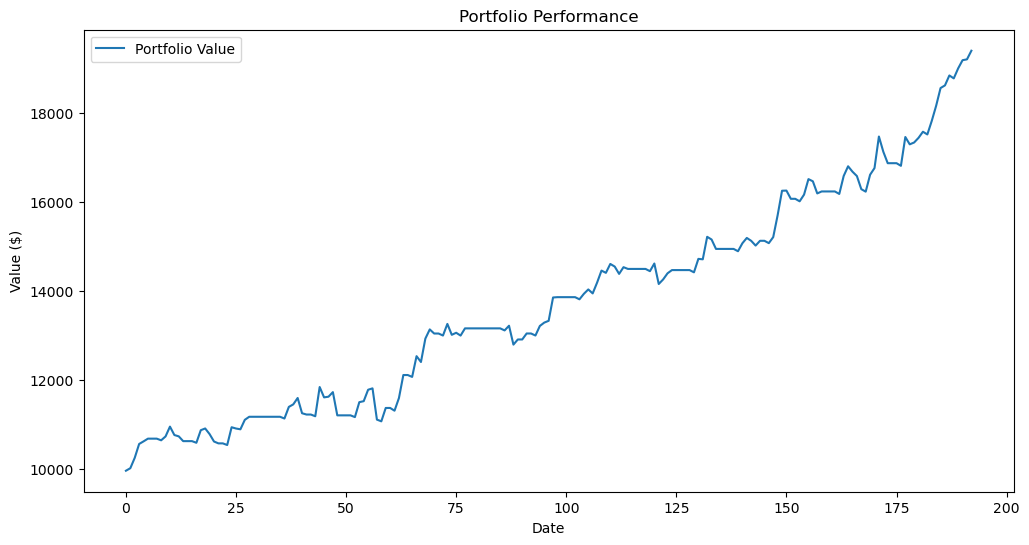

In [43]:
# Step 1: Generate Signals
# Add predicted probabilities and signals to the test set
test_df = X_test.copy()
# test_df['Close/Last'] = y_test.index.map(df.set_index('Date')['Close/Last'])  # Add closing prices
# test_df['Close/Last'] = df['Close/Last'].iloc[y_test.index] 
test_df['Close/Last'] = df['Close/Last'].loc[y_test.index]#.values
# test_df['Predicted_Prob'] = y_proba
test_df['Predicted_Prob'] = y_pred
test_df['Signal'] = y_pred

# Step 2: Simulate Trades with Realism
initial_capital = 10000
capital = initial_capital
position = 0
shares_bought = 0
portfolio_value = []
holding_days = 0
buy_price = 0

for i in range(len(test_df)):
    close_price = test_df['Close/Last'].iloc[i]
    
    # Buy Signal
    if test_df['Signal'].iloc[i] == 1 and position == 0:
        buy_price = close_price * (1 + 0.0035)  # Add slippage
        shares_bought = capital / buy_price
        capital = 0
        position = 1
        holding_days = 0
    
    # Sell Signal (after holding period or stop-loss)
    elif position == 1:
        holding_days += 1
        sell_price = close_price * (1 - 0.0035)  # Subtract slippage
        
        # Stop-Loss Check
        if (sell_price / buy_price - 1) <= -0.05:  # 5% stop-loss
            capital = shares_bought * sell_price
            position = 0
        
        # Holding Period Check
        elif holding_days >= 5:  # Hold for 3 days
            capital = shares_bought * sell_price
            position = 0
    
    # Track portfolio value
    portfolio_value.append(capital if position == 0 else shares_bought * close_price)

# Convert portfolio_value to a Series
portfolio = pd.Series(portfolio_value, index=range(len(test_df)))

# Step 3: Calculate Performance Metrics
total_profit = portfolio.iloc[-1] - initial_capital
daily_returns = portfolio.pct_change().dropna()
sharpe_ratio = np.sqrt(252) * (daily_returns.mean() / daily_returns.std())
running_max = portfolio.expanding().max()
drawdown = (portfolio - running_max) / running_max
max_drawdown = drawdown.min()

print("\nBacktesting Results:")
print(f"Total Profit: ${total_profit:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Step 4: Plot Portfolio Performance
plt.figure(figsize=(12, 6))
plt.plot(portfolio, label='Portfolio Value')
plt.title('Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.legend()
plt.show()

In [44]:
test_df

,MA_10_Return,RSI_14_Return,MACD_Hist,Volatility_Return,Volume_MA_10,Range,SP500_Return,VIX_MA_10,Close/Last,Predicted_Prob,Signal
193,0.013598,48.633012,-0.002686,0.042076,28600632.0,22.8500,-0.003435,16.142,439.19,1,1
192,0.007015,46.764981,-0.004157,0.042099,28641897.0,11.6800,0.009128,15.810,441.68,1,1
191,0.004205,46.017609,-0.005317,0.043630,27769267.0,10.3200,0.012557,15.288,451.96,1,1
190,0.006555,49.144345,-0.004249,0.042256,27551617.0,12.8200,0.010326,14.943,465.68,0,0
189,0.005106,48.668853,-0.003602,0.042553,27384379.0,10.2200,0.001343,14.697,468.24,1,1
...,...,...,...,...,...,...,...,...,...,...,...
5,-0.012841,48.805726,-0.000023,0.006881,18958580.3,19.7199,-0.005047,15.914,689.18,1,1
4,-0.013198,49.373710,0.000173,0.006572,19372094.3,28.7500,-0.007609,16.179,697.46,0,0
3,-0.012165,51.523868,0.000861,0.007631,19587319.3,16.1000,0.007225,16.394,704.19,0,0
2,-0.011130,49.159463,0.000693,0.007079,20139295.3,19.1300,0.003909,16.461,704.87,0,0


In [45]:
portfolio

0       9965.122073
1      10021.619611
2      10254.870493
3      10566.174200
4      10624.260023
           ...     
188    18779.446012
189    19005.067494
190    19188.453071
191    19206.982371
192    19400.995046
Length: 193, dtype: float64

In [46]:
importances = model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the results
print(feature_importance_df)

             Feature  Importance
1      RSI_14_Return    0.686933
0       MA_10_Return    0.061804
4       Volume_MA_10    0.050390
5              Range    0.046164
3  Volatility_Return    0.045556
2          MACD_Hist    0.039917
6       SP500_Return    0.036149
7          VIX_MA_10    0.033087


In [47]:
test_og = df[(df['Date'] > '2024-04-30')]
vis = test_df.copy()
vis['Date'] = df['Date'].loc[vis.index]
vis['Close'] = df['Close/Last'].loc[vis.index]

fig = go.Figure()

# Add the actual price line
fig.add_trace(go.Scatter(x=test_og['Date'], y=test_og['Close/Last'], mode='lines', name='Actual Price', line=dict(color='blue', width=2)))

# Add buy signals
fig.add_trace(go.Scatter(x=vis[vis['Signal'] == 1]['Date'], y=vis[vis['Signal'] == 1]['Close'], mode='markers', name='Buy Signal', marker=dict(color='green', symbol='triangle-up', size=10)))

# Add sell signals
fig.add_trace(go.Scatter(x=vis[vis['Signal'] == 0]['Date'], y=vis[vis['Signal'] == 0]['Close'], mode='markers', name='Sell Signal', marker=dict(color='red', symbol='triangle-down', size=10)))

# Update layout
fig.update_layout(
    title='Actual Price vs. Model Predictions',
    xaxis_title='Date',
    yaxis_title='Price ($)',
    legend=dict(x=0, y=1, traceorder='normal')
)

# Show the plot
fig.show()

In [48]:
# plot_html = fig.to_html(full_html=False, include_plotlyjs='cdn')

In [49]:
# print(plot_html)

In [50]:
fig.write_html("price_vs_predictions.html")

In [51]:
vis

,MA_10_Return,RSI_14_Return,MACD_Hist,Volatility_Return,Volume_MA_10,Range,SP500_Return,VIX_MA_10,Close/Last,Predicted_Prob,Signal,Date,Close
193,0.013598,48.633012,-0.002686,0.042076,28600632.0,22.8500,-0.003435,16.142,439.19,1,1,2024-05-01,439.19
192,0.007015,46.764981,-0.004157,0.042099,28641897.0,11.6800,0.009128,15.810,441.68,1,1,2024-05-02,441.68
191,0.004205,46.017609,-0.005317,0.043630,27769267.0,10.3200,0.012557,15.288,451.96,1,1,2024-05-03,451.96
190,0.006555,49.144345,-0.004249,0.042256,27551617.0,12.8200,0.010326,14.943,465.68,0,0,2024-05-06,465.68
189,0.005106,48.668853,-0.003602,0.042553,27384379.0,10.2200,0.001343,14.697,468.24,1,1,2024-05-07,468.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,-0.012841,48.805726,-0.000023,0.006881,18958580.3,19.7199,-0.005047,15.914,689.18,1,1,2025-01-31,689.18
4,-0.013198,49.373710,0.000173,0.006572,19372094.3,28.7500,-0.007609,16.179,697.46,0,0,2025-02-03,697.46
3,-0.012165,51.523868,0.000861,0.007631,19587319.3,16.1000,0.007225,16.394,704.19,0,0,2025-02-04,704.19
2,-0.011130,49.159463,0.000693,0.007079,20139295.3,19.1300,0.003909,16.461,704.87,0,0,2025-02-05,704.87


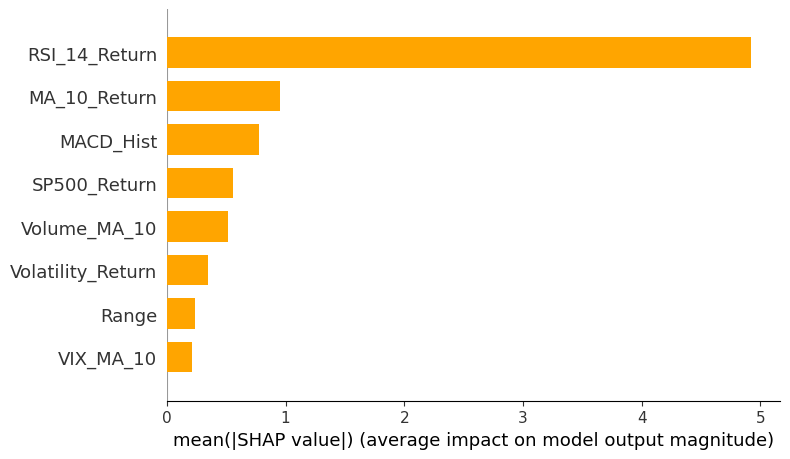

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, color='orange')

In [53]:
import plotly.express as px
import plotly.graph_objects as go

# Plot portfolio performance
fig = go.Figure()
fig.add_trace(go.Scatter(x=vis['Date'], y=portfolio, name='Portfolio Value'))
fig.update_layout(title='Portfolio Performance Over Time', xaxis_title='Day', yaxis_title='Value ($)',)
fig.show()

# Plot Sharpe Ratio and Drawdown
metrics_fig = go.Figure()
metrics_fig = go.Figure()
metrics_fig.add_trace(go.Indicator(
    mode="number",
    value=sharpe_ratio,
    title={"text": f"Sharpe Ratio:"},
    domain={'row': 0, 'column': 0}
))
metrics_fig.add_trace(go.Indicator(
    mode="number",
    value=max_drawdown,
    title={"text": f"Max Drawdown:"},
    domain={'row': 0, 'column': 1}
))
metrics_fig.update_layout(grid={'rows': 1, 'columns': 2})
metrics_fig.show()

In [80]:
fig.write_html("portfolio_performance.html")

In [54]:
# param_grid = {
#     'n_estimators': [100, 200, 250],
#     'max_depth': [3, 5, 7, 10, None],
#     'min_samples_split': [2, 5, 7, 10]
# }

# # Initialize the model
# model = RandomForestClassifier(random_state=42)

# # Perform grid search
# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Print the best parameters
# print(f'Best Parameters: {grid_search.best_params_}')

# # Train the model with the best parameters
# # best_model = grid_search.best_estimator_
# best_model.fit(X_train, y_train)

# # Make predictions
# y_pred = best_model.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# # Print the results
# print(f'Random Forest Results:')
# print(f'Accuracy: {accuracy:.2f}')
# print(f'Precision: {precision:.2f}')
# print(f'Recall: {recall:.2f}')
# print(f'F1-Score: {f1:.2f}')

In [55]:
# RandomForestClassifier(max_depth=3, min_samples_split=2, n_estimators=250, random_state=42)

# # Train the model
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# # Calculate metrics
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# # Print the results
# print(f'Accuracy: {accuracy:.2f}')
# print(f'Precision: {precision:.2f}')
# print(f'Recall: {recall:.2f}')
# print(f'F1-Score: {f1:.2f}')

---

**XGBoost**  is a powerful gradient-boosting algorithm

In [56]:
# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1]
# }

# # Initialize the model
# model = XGBClassifier(random_state=42)

# # Perform grid search
# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Print the best parameters
# print(f'Best Parameters: {grid_search.best_params_}')

# # Train the model with the best parameters
# best_model = grid_search.best_estimator_
# best_model.fit(X_train, y_train)

# # Make predictions
# y_pred = best_model.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# # Print the results
# print(f'XGBoost Results:')
# print(f'Accuracy: {accuracy:.2f}')
# print(f'Precision: {precision:.2f}')
# print(f'Recall: {recall:.2f}')
# print(f'F1-Score: {f1:.2f}')

Chose LogisticRegression as ML model

In [57]:
# # Define the parameter grid
# param_grid = {
#     'C': [0.01, 0.1, 1, 10],  # Regularization strength
#     'penalty': ['l1', 'l2']    # Regularization type
# }

# # Initialize the model
# model = LogisticRegression(random_state=42, solver='liblinear')

# # Perform grid search
# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Print the best parameters
# print(f'Best Parameters: {grid_search.best_params_}')

# # Train the model with the best parameters
# best_model = grid_search.best_estimator_
# best_model.fit(X_train, y_train)

# # Make predictions
# y_pred = best_model.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# # Print the results
# print(f'Logistic Regression Results:')
# print(f'Accuracy: {accuracy:.2f}')
# print(f'Precision: {precision:.2f}')
# print(f'Recall: {recall:.2f}')
# print(f'F1-Score: {f1:.2f}')

In [58]:
# print(X_train.describe())

In [59]:
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# print(f'Accuracy: {accuracy:.2f}')
# print(f'Precision: {precision:.2f}')
# print(f'Recall: {recall:.2f}')
# print(f'F1-Score: {f1:.2f}')

In [60]:
# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier()
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

In [61]:
# from sklearn.model_selection import GridSearchCV

# # Define hyperparameters to tune
# param_grid = {
#     'n_estimators': [50, 100, 200, 500, 750],
#     'max_depth': [None, 2, 5, 10, 20, 50]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Print the best parameters
# print(grid_search.best_params_)

In [62]:
# model = RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42)

# # Train the model
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# # Calculate metrics
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# # Print the results
# print(f'Accuracy: {accuracy:.2f}')
# print(f'Precision: {precision:.2f}')
# print(f'Recall: {recall:.2f}')
# print(f'F1-Score: {f1:.2f}')

In [63]:
# from sklearn.model_selection import cross_val_score

# # Perform cross-validation
# scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# # Print the results
# print(f'Cross-Validation Accuracy: {scores.mean():.2f} (± {scores.std():.2f})')

In [64]:
# from xgboost import XGBClassifier

# # Initialize the model
# model = XGBClassifier(max_depth=5, n_estimators=200, learning_rate=0.1, random_state=42)

# # Train the model
# model.fit(X_train, y_train)

# # Evaluate the model
# y_pred = model.predict(X_test)
# print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

In [65]:
# train_start_date = '2018-03-01'
# train_end_date = '2024-04-07'  # Right before price hit 500
# test_start_date = '2024-04-08'
# test_end_date = '2025-02-06'

# # Create train and test sets
# train_data = df[(df['Date'] >= train_start_date) & (df['Date'] <= train_end_date)]
# test_data = df[(df['Date'] >= test_start_date) & (df['Date'] <= test_end_date)]

# # Features (X) and target (y)
# X_train, y_train = train_data.drop(columns=['Date', 'Target']), train_data['Target']
# X_test, y_test = test_data.drop(columns=['Date', 'Target']), test_data['Target']

# # Verify the split
# print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

In [66]:
# model = LogisticRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# # Print the results
# print(f'Accuracy: {accuracy:.2f}')
# print(f'Precision: {precision:.2f}')
# print(f'Recall: {recall:.2f}')
# print(f'F1-Score: {f1:.2f}')

In [67]:
# model = LogisticRegression(penalty='l2', max_iter=1000)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# # Print the results
# print(f'Accuracy: {accuracy:.2f}')
# print(f'Precision: {precision:.2f}')
# print(f'Recall: {recall:.2f}')
# print(f'F1-Score: {f1:.2f}')

In [68]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

# # Define feature scaling and model in a pipeline
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),  # Standardize features
#     ('logreg', LogisticRegression(max_iter=1000))  # Logistic Regression model
# ])

# # Define hyperparameters to tune
# param_grid = {
#     'logreg__C': [0.01, 0.1, 1, 10, 25],  # Regularization strength
#     'logreg__penalty': ['l1', 'l2'],  # Regularization type
#     'logreg__solver': ['liblinear']  # Solver that supports L1 penalty
# }

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Best parameters and accuracy
# print("Best Parameters:", grid_search.best_params_)
# print("Best Accuracy:", grid_search.best_score_)

In [69]:
# final_model = Pipeline([
#     ('scaler', StandardScaler()),  # Standardize features
#     ('logreg', LogisticRegression(C=10, penalty='l2', solver='liblinear', max_iter=1000))
# ])

# # Train the model on the full training data
# final_model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = final_model.predict(X_test)
# y_proba = final_model.predict_proba(X_test)[:, 1]  # Probability scores for ROC-AUC

In [70]:
# model = RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

# # Train the model
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# # Calculate metrics
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

# # Print the results
# print(f'Accuracy: {accuracy:.2f}')
# print(f'Precision: {precision:.2f}')
# print(f'Recall: {recall:.2f}')
# print(f'F1-Score: {f1:.2f}')

In [71]:
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform

# param_dist = {'logreg__C': uniform(0.01, 100)}

# random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1)
# random_search.fit(X_train, y_train)

# print("Best Parameters:", random_search.best_params_)
# print("Best Accuracy:", random_search.best_score_)
